
# Chapter 8



# Lab: Tree-Based Methods
We import some of our usual libraries at this top
level.

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS


We also  collect the new imports
needed for this lab.

In [2]:
from sklearn.tree import (DecisionTreeClassifier as DTC, #calssification tree
                          DecisionTreeRegressor as DTR,  #regression tree
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
#from sklearn.ensemble import \
#     (RandomForestRegressor as RF,
#      GradientBoostingRegressor as GBR)
from ISLP.bart import BART


## Fitting Regression Trees
Here we fit a regression tree to the  `Boston`  data set. The
steps are similar to those for classification trees.

In [14]:
Boston = load_data("Boston")
model = MS(Boston.columns.drop('medv'), intercept=False) # 不包含常數項
D = model.fit_transform(Boston)
feature_names = list(D.columns)
X = np.asarray(D)


First, we split the data into training and test sets, and fit the tree
to the training data. Here we use 30% of the data for the test set.


In [15]:
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                Boston['medv'],
                                test_size=0.3,
                                random_state=0)


Having formed  our training  and test data sets, we fit the regression tree.

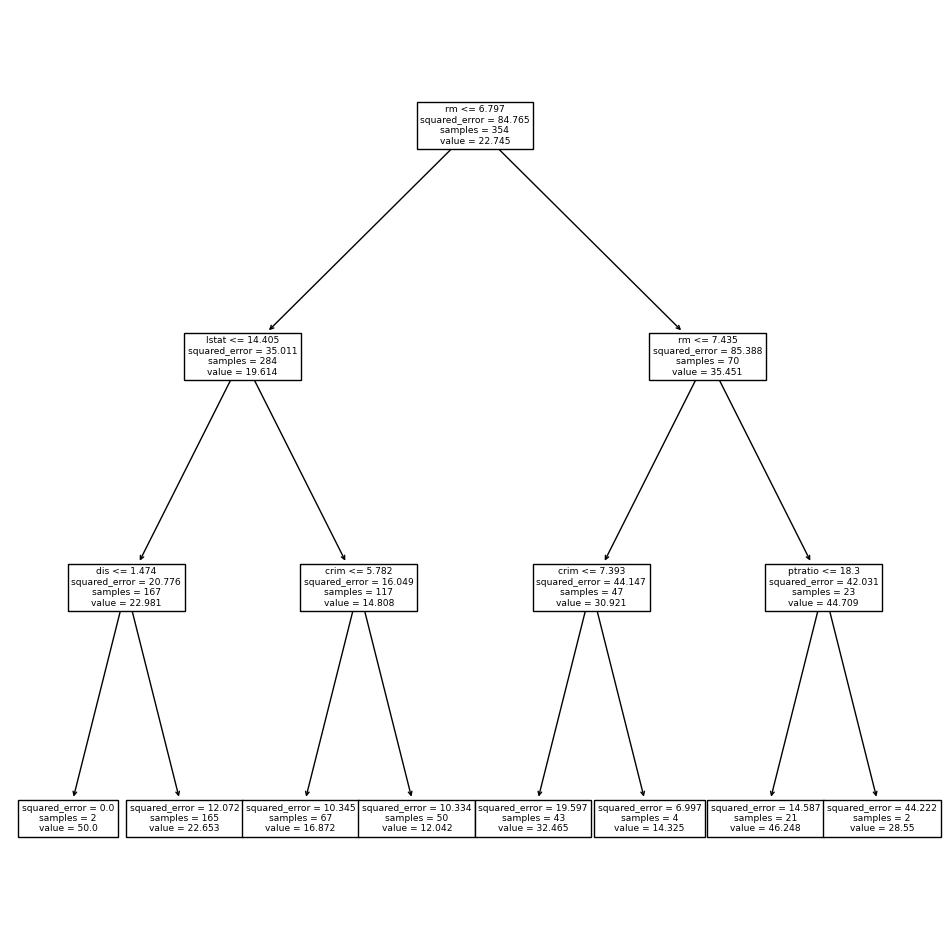

In [16]:
reg = DTR(max_depth=3) #tunning parameters
reg.fit(X_train, y_train)
ax = subplots(figsize=(12,12))[1]
plot_tree(reg,                          #sklearn
          feature_names=feature_names,
          ax=ax);


The variable `lstat` measures the percentage of individuals with
lower socioeconomic status. The tree indicates that lower
values of `lstat` correspond to more expensive houses.
The tree predicts a median house price of $12,042 for small-sized homes (`rm < 6.8`), in
suburbs in which residents have low socioeconomic status (`lstat  > 14.4`) and the crime-rate is moderate (`crim > 5.8`).

Now we use the cross-validation function to see whether pruning
the tree will improve performance.

In [17]:
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5,           # 5-fold CV
                  shuffle=True, # 分群時打亂資料
                  random_state=10) #設定 seed
grid = skm.GridSearchCV(reg,
                        {'ccp_alpha': ccp_path.ccp_alphas}, #目標參數: Effective alphas of subtree during pruning.
                        refit=True, #Refit an estimator using the best found parameters on the whole dataset
                        cv=kfold,   #cv分法
                        scoring='neg_mean_squared_error') #透過呼叫sklearn.metrics下的 mean_absolute_error() 來進行計算
G = grid.fit(X_train, y_train)



sklearn.metrics下的 mean_absolute_error() 計算結果中的 scoring 的類型可參考以下網址
https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules

"scoring" 是用來選擇最好的 tunning parameters, score(分數) 越大越好，因此在這裡使用 $-MSE$(mean square error)。


In [19]:
#?reg.cost_complexity_pruning_path
#?skm.GridSearchCV

Init signature:
skm.GridSearchCV(
    estimator,
    param_grid,
    *,
    scoring=None,
    n_jobs=None,
    refit=True,
    cv=None,
    verbose=0,
    pre_dispatch='2*n_jobs',
    error_score=nan,
    return_train_score=False,
)
Docstring:     
Exhaustive search over specified parameter values for an estimator.

Important members are fit, predict.

GridSearchCV implements a "fit" and a "score" method.
It also implements "score_samples", "predict", "predict_proba",
"decision_function", "transform" and "inverse_transform" if they are
implemented in the estimator used.

The parameters of the estimator used to apply these methods are optimized
by cross-validated grid-search over a parameter grid.

Read more in the :ref:`User Guide <grid_search>`.

Parameters
----------
estimator : estimator object
    This is assumed to implement the scikit-learn estimator interface.
    Either estimator needs to provide a ``score`` function,
    or ``scoring`` must be passed.

param_grid : dict or lis

In keeping with the cross-validation results, we use the pruned tree
to make predictions on the test set.

In [22]:
best_ = grid.best_estimator_
np.mean((y_test - best_.predict(X_test))**2)


28.06985754975404

In other words, the test set MSE associated with the regression tree
is 28.07.  The square root of
the MSE is therefore around
5.30,
indicating that this model leads to test predictions that are within around
$5300
of the true median home value for the suburb.

Let’s plot the best tree to see how interpretable it is.

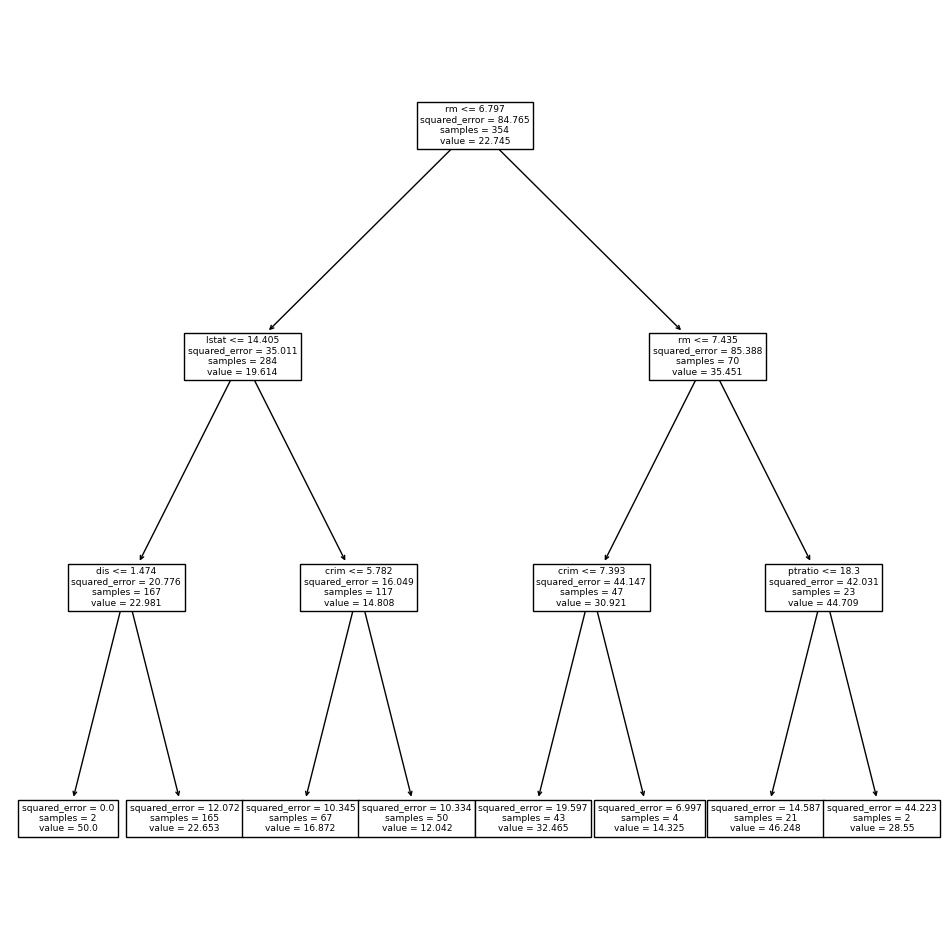

In [23]:
ax = subplots(figsize=(12,12))[1]
plot_tree(G.best_estimator_,
          feature_names=feature_names,
          ax=ax);
